**Executed:** Sun Feb  9 13:24:11 2020<br>**Duration:** 117 seconds.<br>**Autogenerated from:** [Base Experiment.ipynb](saved experiments/Baseline Augmentation + VGG16 Model + epoch100 + opt-adam.ipynb)

---

Error occurred during execution. See below.

In [1]:
# NOTEBOOK parameters
# see nbrun docs on github

IMG_SHAPE = (150,150)
BATCH_SIZE = 32
EPOCH = 15
MODEL = 'Inception-ResNet V2 Model' # 'Lite Test' # 
DATA_GEN_CONFIG = 'Baseline Augmentation'
OPT = 'opt-adam-lr2e-05'
AUTO=False

In [2]:
# Cell inserted during automated execution.
DATA_GEN_CONFIG = 'Baseline Augmentation'
MODEL = 'VGG16 Model'
EPOCH = 100
OPT = 'opt-adam'
AUTO = True

In [3]:
!curl -L -o noahs_utils.py https://gist.github.com/bantucaravan/1956003e25c056c550a088542b41dc91/raw/noahs_utility_funcs.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


100 12781  100 12781    0     0  23300      0 --:--:-- --:--:-- --:--:-- 23300


In [4]:
import os
import glob
import re
import datetime as dt
from collections import defaultdict
import sys
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

#import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense

from noahs_utils import *
import build_data_gens
import build_models

In [5]:
if False:
    import noahs_utils
    importlib.reload(noahs_utils)

In [6]:
if False:
    import GIST_git_clone.noahs_utility_funcs
    from GIST_git_clone.noahs_utility_funcs import *
    importlib.reload(GIST_git_clone.noahs_utility_funcs)

**Data** from https://www.kaggle.com/asdasdasasdas/garbage-classification

Get number of images in each class folder

In [7]:
img_dir = '/Users/noahchasekmacfoy/Desktop/local projects/Trash-life/data/Garbage Classification Dataset/IMAGES'
tot_len = 0
for _dir in [i for i in os.listdir(img_dir) if not i.startswith('.')]:
    _len = len(os.listdir(os.path.join(img_dir, _dir)))
    tot_len += _len
    print(_dir, ': ', _len)
print(tot_len)

paper :  594
metal :  410
cardboard :  403
trash :  137
glass :  501
plastic :  482
2527


Listed test/val/train split from txt files

In [8]:
#file = '../data/Garbage Classification Dataset/one-indexed-files-notrash_test.txt'
files = glob.glob('../data/Garbage Classification Dataset/*_*.txt')
files = {re.findall(r'.*_(\w*).txt',f)[0]: pd.read_csv(f, sep=' ', header=None) for i, f in enumerate(files)}

Create df listing train/val/test split

In [9]:
df = pd.concat(files.values(), axis=0, keys=files.keys()).reset_index(level=0)
df.columns = ['split', 'img', '1-indexed-label']
df.index = range(len(df))
df['label'] = df['img'].str.extract(r'([a-z]+)\d+.jpg')
df

,split,img,1-indexed-label,label
0,test,paper70.jpg,2,paper
1,test,paper380.jpg,2,paper
2,test,cardboard31.jpg,3,cardboard
3,test,glass12.jpg,1,glass
4,test,paper169.jpg,2,paper
...,...,...,...,...
2522,train,cardboard6.jpg,3,cardboard
2523,train,glass283.jpg,1,glass
2524,train,metal335.jpg,5,metal
2525,train,plastic133.jpg,4,plastic


In [10]:
print('total listed images:', df.shape[0],'\n')
print('test/val/train split:')
df.groupby('split').size()/df.shape[0]

total listed images: 2527 

test/val/train split:


split
test     0.170558
train    0.699644
val      0.129798
dtype: float64

Create symlink dirs representing Train / Val / Test

In [11]:
tmp_dir = '../data/Garbage Classification Dataset/tmp images/'
# create dirs
for split in df.split.unique():
    for label in df.label.unique():
        os.makedirs(os.path.join(tmp_dir,split,label), exist_ok=True)
for i in df.index:
    try:
        src = os.path.join(img_dir, df.loc[i, 'label'], df.loc[i, 'img'])
        dst = os.path.join(tmp_dir, df.loc[i, 'split'], df.loc[i, 'label'], df.loc[i, 'img'])
        #print('src:', os.path.exists(src))
        #print('dst:', os.path.exists(dst))
        os.symlink(src, dst)
    except FileExistsError:
        pass

Set up train / val data generators

In [12]:
#### Import pre-configed data_gens
train_gen_config, val_gen_config = build_data_gens.get_gen_config(DATA_GEN_CONFIG)


In [13]:
train_gen = train_gen_config.flow_from_directory(os.path.join(tmp_dir,'train'),
                                                target_size=IMG_SHAPE,
                                                follow_links=True)
val_gen = val_gen_config.flow_from_directory(os.path.join(tmp_dir,'val'),
                                                target_size=IMG_SHAPE,
                                                follow_links=True)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.


In [14]:
len(val_gen)

11

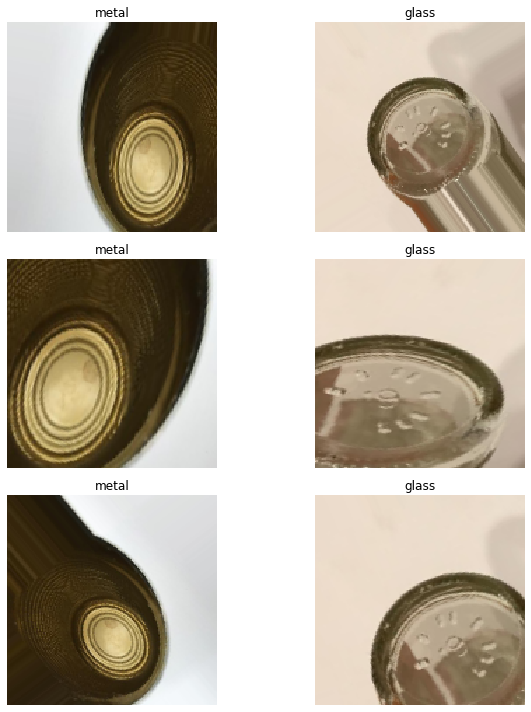

In [15]:
#Look at n random augmentations of the first 2 images from the first batch
#Issue: insure viz of each class transformed
classes =list(train_gen.class_indices.keys())
n=3
fig, axes = plt.subplots(n,2, figsize=(10,10))
for i in range(n):
    batch = train_gen[0] # returns first batch
    ax = plot_image(batch[0][0], ax= axes[i, 0])
    cls = classes[np.argmax(batch[1][0])]
    ax.set(title = cls)
    ax.axis('off')
    #plt.show()
    ax = plot_image(batch[0][1], ax=axes[i, 1])
    cls = classes[np.argmax(batch[1][1])]
    ax.set(title = cls)
    ax.axis('off') 
plt.tight_layout()
    #plt.show()

In [16]:
len(train_gen)

56

In [17]:
train_gen[0][0].shape

(32, 150, 150, 3)

In [18]:
train_gen[55][0].shape

(8, 150, 150, 3)

### Build model

Baseline  
Baseline + Dropout  
Baseline + Data Augmentation  
Baseline + Dropout + Data Augmentation  

In [19]:
ts = dt.datetime.now().strftime('%Y-%m-%d_%Hh%Mm%Ss')
ts

'2020-02-09_13h24m18s'

In [20]:
# Callbacks
bestmodelpath = '../saved models/model_epoch{epoch:02d}_{val_accuracy:.2f}_%s.h5' %(ts)
mc = ModelCheckpoint(bestmodelpath, monitor='val_accuracy', verbose=1, save_best_only=True)

tb = TensorBoard(log_dir='../tb_logs/'+ts,
                 histogram_freq=3,# allows wt histograms per epoch
                 #write_graph=True,# are these taking lots of disk space?
                 #write_images=True,
                 update_freq='epoch',
                 #write_grads=True,
                 profile_batch=1)
                

callback_list=[mc] #, tb] # tensorboard (at least with these settings is super storage intensive)

In [21]:
#### Import model

# get model achitecture
model = build_models.get_model(desc=MODEL, IMG_SHAPE=IMG_SHAPE, OPT=OPT)


0.01
IMG_SHAPE: (150, 150)
OPT: opt-adam


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 14,847,558
Trainable params: 132,870
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
%%time
print('Starting to fit model...')
history = model.fit(train_gen,
           validation_data=val_gen,
           steps_per_epoch=len(train_gen),
           validation_steps=len(val_gen),
           epochs=EPOCH,
           callbacks=callback_list,
           verbose=.5
          )

Starting to fit model...
  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 56 steps, validate for 11 steps
Epoch 1/100



Epoch 00001: val_accuracy improved from -inf to 0.51524, saving model to ../saved models/model_epoch01_0.52_2020-02-09_13h24m18s.h5
Epoch 2/100


### Evaluate Model

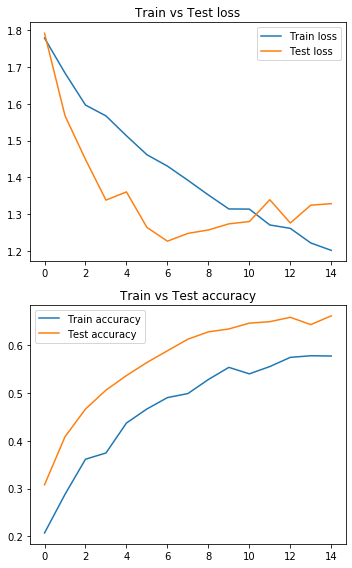

In [23]:
imgpath = '../figs/Train Test %s %s.png' %('accuracy', ts)
plot_tf_training(history, metric='accuracy', save=imgpath)

In [24]:
#ts = '2020-02-07_00h05m06s'
#sorted(glob.glob('../saved models/model_*_2020-02-06_23:35:05.h5'))[-1]
get_loss = lambda x: float(re.findall(r'_(\d\.\d{2})_', x)[0])
opt_idx = -1 if 'accuracy' in bestmodelpath else 0 # choose first of last depending acc or loss
pat = '../saved models/model_epoch*_*_%s.h5' %(ts)
bestmodelpath = sorted(glob.glob(pat), key=get_loss)[opt_idx]
print(bestmodelpath)

../saved models/model_epoch07_1.23_2020-02-08_19h34m10s.h5


In [25]:
# write something to delete albut best?? (always latest?) model path
# glob for best model path around epoch????
bestmodel = load_model(bestmodelpath)

In [26]:
ytrue = val_gen.classes[val_gen.index_array]
proba_preds = bestmodel.predict(val_gen, steps=len(val_gen))
preds = np.argmax(proba_preds, axis=1)

In [27]:
out = metrics_report(ytrue, preds, classnames=val_gen.class_indices.keys())
out

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,cardboard,glass,metal,paper,plastic,trash,accuracy,macro avg,weighted avg
precision,0.738095,0.505376,0.555556,0.677419,0.506849,0.0,0.588415,0.497216,0.564197
recall,0.673913,0.723077,0.267857,0.759036,0.606557,0.0,0.588415,0.505073,0.588415
f1-score,0.704545,0.594937,0.361446,0.715909,0.552239,0.0,0.588415,0.488179,0.562280
support,46.000000,65.000000,56.000000,83.000000,61.000000,17.0,0.588415,328.000000,328.000000


In [28]:
val_gen.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

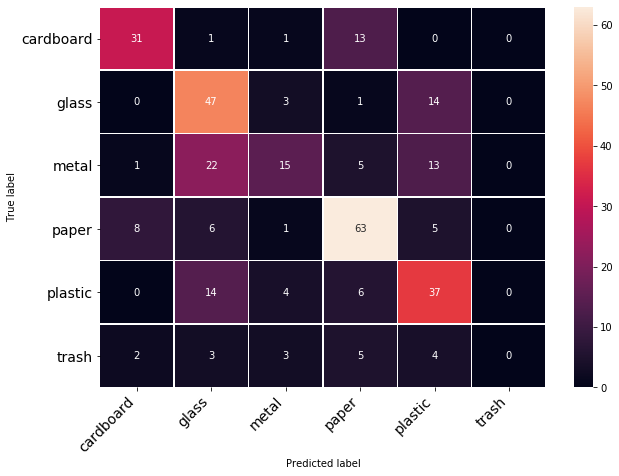

In [29]:
cm = confusion_matrix(ytrue, preds, class_names=val_gen.class_indices.keys())

In [30]:
top_epochs(history, metric='loss')

Best loss by epoch (1-indexed):


{1: 1.7920676036314531,
 2: 1.5678254040804775,
 3: 1.4489597298882224,
 5: 1.3607638586651196,
 12: 1.339417284185236,
 4: 1.3384553302418103,
 15: 1.328770474954085,
 14: 1.3246987136927517,
 11: 1.2801327813755383,
 13: 1.2762747406959534,
 10: 1.2739016305316577,
 6: 1.2642319473353298,
 9: 1.2572396451776677,
 8: 1.2479918219826438,
 7: 1.2267777052792637}

In [31]:
top_epochs(history)

Best accuracy by epoch (1-indexed):


{15: 0.6615854,
 13: 0.6585366,
 12: 0.6493902,
 11: 0.64634144,
 14: 0.64329267,
 10: 0.63414633,
 9: 0.6280488,
 8: 0.6128049,
 7: 0.5884146,
 6: 0.5640244,
 5: 0.5365854,
 4: 0.50609756,
 3: 0.46646342,
 2: 0.40853658,
 1: 0.30792683}

In [32]:
# should keras drop out be applied after maxpool or before

#### Write Log

In [33]:
logdict = defaultdict(dict)
# data prep deets
logdict['train_data_gen_config'].update(vars(train_gen_config))
# to avoid saving the file name of everysingle image
logdict['train_data_gen'].update({k:v for k,v in vars(train_gen).items() if not isinstance(v,(np.ndarray, list))})

logdict['val_data_gen_config'].update(vars(val_gen_config))
logdict['val_data_gen'].update({k:v for k,v in vars(val_gen).items() if not isinstance(v,(np.ndarray, list))})

# model deets
logdict.update({'model_config': history.model.get_config()})# to_json() not used bc it returns string
logdict.update({'opt_config': history.model.optimizer.get_config()})
logdict.update({'model_history': history.history}) 
logdict.update({'fit_params': history.params})
logdict.update({'bestmodelpath': bestmodelpath})


# model val data metrics
logdict.update({'metrics_report': out.to_dict()})
logdict.update({'confusion_matrix': cm.to_dict()})

# misc
logdict.update({'run_id':ts})
logdict.update({'MODEL':MODEL, 'DATA_GEN_CONFIG':DATA_GEN_CONFIG, 'EPOCH': EPOCH})
logdict.update({'bestmodelpath': bestmodelpath})

In [34]:
dct = {ts: logdict} #; dct
logpath = '../logs/model_log.json'
write_log_json(dct, logpath, cls=NumpyEncoder)

In [36]:
# save html copy....
if not AUTO:
    outname = '../saved experiments/' f'{DATA_GEN_CONFIG} + {MODEL} + epoch{EPOCH} + {OPT}' + '.html'
    nbname = 'Base Experiment.ipynb'
    !jupyter nbconvert $nbname --to html --output $outname
    print('Exporting html')

**Diagnostics**

loss/acc by epoch graph  
classification report  
visualize filters?  
visualize mispredicted values?  
plot class level acc/metrics by epoch